#Setup

In [ ]:
import copy                       # Used to create fresh deep copies of puzzle states when creating new nodes
import heapq                      # Used to hold edge states
import time                       # Used to compare performance of heuristic scores
import matplotlib.pyplot as plt   # Used to visualize performence metrics

#Heuristic Scores

In [ ]:
def manhattan_distance_score(puzzle):                   # Compares every entry of the puzzle to its ideal location
  size = len(puzzle)
  score = 0

  for row in range(size):
    for col in range(size):
      entry = puzzle[row][col]
      di, dj = int((entry-1)/size), (entry - 1) % size  # Calculate ideal coordinates for the integer at 'entry'

      if entry != 0:
        score += abs(row - di) + abs(col - dj)          # Calculate the difference between actual and ideal location

  return score

In [ ]:
def misplaced_tile_score(puzzle):                                                   # Calculates the number of entries that are not in their proper place
  size = len(puzzle)
  score = 0
  for row in range(size):
    for col in range(size):
      if puzzle[row][col] != 0 and puzzle[row][col] != (size * row) + (col + 1):    # Determine what value should be at this position and increment score if not equal to actual value
        score += 1
  return score

#Node Code

In [ ]:
class Node:
  def __init__(self, state, zero, g = 0, h = 0, children = [], parent = None):
    self.state    = copy.deepcopy(state)      # The array representation of the puzzle
    self.zero     = zero                      # The i,j coordinates of 0
    self.g        = g                         # Current cost for this node (important for maintaining search order)
    self.h        = h                         # Heuristic estimate cost for this node
    self.children = children                  # Array of child nodes
    self.parent   = parent                    # Parent node

  def to_tuple(self):                         # Convert puzzle array to tuple to hash visited states into dictionary
    tup = []
    for row in self.state:
      tup.append(tuple(row))
    return tuple(tup)

  def __lt__(self, other):                    # Used when comparing two nodes for queue ordering compares the g and h scores of this node and another node
    return self.g + self.h < other.g + other.h

  def __str__(self):                          # Prints the contents of the nodes variables
    puzStr = ""
    for row in self.state:
      puzStr += str(row) + "\n"
    return puzStr + " g(n): " +  str(self.g) + " h(n): " + str(self.h) + " f(n) " + str(self.g + self.h)

In [ ]:
def MAKE_NODE(state):                         # Initializes a node without having to specify the index of value 0. Assumes starting node. Leaves all other fields default
  for i in range(len(state)):
    for j in range(len(state)):
      if state[i][j] == 0:
        return Node(state, (i, j))

#Backbone Definitions

In [ ]:
class NPuzProb:
  def __init__(self, INITIAL_STATE):
    self.INITIAL_STATE  = copy.deepcopy(INITIAL_STATE)                                      # The starting puzzle array for this instance of the n puzzle problem
    self.OPERATORS      = [self.Swap_Up, self.Swap_Left, self.Swap_Down, self.Swap_Right]   # The array of functions which define the possible moves that can be made
    self.size           = len(INITIAL_STATE)                                                # the size of an arbitrary square n-puzzle

  def Goal_Test(self, state):                                                               # Recycle misplaced tile score to check for goal state
    return misplaced_tile_score(state) == 0

  def Swap_Up(self, node):                                                                  # Check if 0 can be swapped with entry above and if so return a new array with the swapped values and the new index of 0
    i, j = node.zero                                                                        # Other operators function in simlar fashion

    if i > 0:
      s = copy.deepcopy(node.state)
      s[i][j], s[i - 1][j], = s[i - 1][j], s[i][j]
      return s, (i - 1, j)

  def Swap_Left(self, node):
    i, j = node.zero

    if j > 0:
      s = copy.deepcopy(node.state)
      s[i][j], s[i][j - 1], = s[i][j - 1],s[i][j]
      return s, (i, j - 1)

  def Swap_Down(self, node):
    i, j = node.zero

    if i < self.size - 1:
      s = copy.deepcopy(node.state)
      s[i][j], s[i + 1][j], = s[i + 1][j], s[i][j]
      return s, (i + 1, j)

  def Swap_Right(self, node):
    i, j = node.zero

    if j < self.size - 1:
      s = copy.deepcopy(node.state)
      s[i][j], s[i][j + 1], = s[i][j + 1], s[i][j]
      return s, (i, j + 1)

In [ ]:
def EXPAND(node, operators, visited_states):                          # Expand all possible states from a given node using the operators defined in 'problem'.
  c = []                                                              # Do not pass through visited nodes to be added to the search space

  for op in operators:
    temp = op(node)

    if temp:
      s, z = temp
      n = Node(state = s, zero = z, g = node.g + 1, parent = node)

      if n.to_tuple() not in visited_states:
        visited_states[n.to_tuple()] = "seen"
        c.append(n)

  node.children = c
  return node.children

#Queue Management

In [ ]:
def MAKE_QUEUE(arr):                          #Turn an array into a queue
  heapq.heapify(arr)
  return arr

In [ ]:
def manhattan_queuing(q, nodes):              # Adds 'nodes' to the queue using the manhattan heuristic
  for n in nodes:
    n.h = manhattan_distance_score(n.state)
    heapq.heappush(q, n)
  return q

In [ ]:
def misplaced_queuing(q, nodes):              # Adds 'nodes' to queue using the misplaced tile heuristic
  for n in nodes:
    n.h = misplaced_tile_score(n.state)
    heapq.heappush(q, n)
  return q

In [ ]:
def uniform_cost_queuing(q, nodes):           # Use no heuristic. Simple queues nodes using their g cost
  for n in nodes:
    heapq.heappush(q, n)
  return q

#General Search

In [ ]:
def general_search(problem, QUEUEING_FUNCTION):                                         # Nearly identical to the general search seen in slides. With added variables to track performance and a dictionary do track visited states
  visited_states  = {}
  max_q_size      = 0
  nodes_visited   = 0
  start_time      = time.time()

  nodes = MAKE_QUEUE([MAKE_NODE(problem.INITIAL_STATE)])
  visited_states[nodes[0].to_tuple] = "visited"

  while nodes:
    max_q_size = max(max_q_size, len(nodes))

    node = heapq.heappop(nodes)
    nodes_visited += 1

    if problem.Goal_Test(node.state):
      runtime = round(time.time() - start_time, 2)
      print("Solution depth: ", node.g, " Maximum queue size: ", max_q_size, " Nodes visited: ", nodes_visited, " Total runtime: ", runtime)
      return node, max_q_size, nodes_visited, runtime

    nodes = QUEUEING_FUNCTION(nodes, EXPAND(node, problem.OPERATORS, visited_states))
  return "failure"

#Utility Functions

In [ ]:
def ancestry(node):         #Traces back from solution node through parents to initial node to present a solution path trace
  a = []
  n = node
  while n:
    a.append(n)
    n = n.parent
  return a[::-1]

#Testing Area

In [ ]:
test_puzzles = [[[1,2,3],
                 [4,5,6],
                 [7,8,0]],
                [[1,2,3],
                 [4,5,6],
                 [0,7,8]],
                [[1,2,3],
                 [5,0,6],
                 [4,7,8]],
                [[1,3,6],
                 [5,0,2],
                 [4,7,8]],
                [[1,3,6],
                 [5,0,7],
                 [4,8,2]],
                [[1,6,7],
                 [5,0,3],
                 [4,8,2]],
                [[7,1,2],
                 [4,8,5],
                 [6,3,0]],
                [[0,7,2],
                 [4,6,1],
                 [3,5,8]]]

In [ ]:

queuing_functions = [uniform_cost_queuing, misplaced_queuing, manhattan_queuing]
solutions = {}

for q in queuing_functions:
  qSolns = []

  for t in test_puzzles:
    prob = NPuzProb(t)
    qSolns.append(general_search(prob, q))

  solutions[q.__name__] = qSolns

x_depth = []

uc_q = []
uc_n = []
uc_r = []

for s in solutions["uniform_cost_queuing"]:
  x_depth.append([s[0].g][0])

  uc_q.append(s[1])
  uc_n.append(s[2])
  uc_r.append(s[3])

mp_q = []
mp_n = []
mp_r = []

for s in solutions["misplaced_queuing"]:
  mp_q.append(s[1])
  mp_n.append(s[2])
  mp_r.append(s[3])

mh_q = []
mh_n = []
mh_r = []

for s in solutions["manhattan_queuing"]:
  mh_q.append(s[1])
  mh_n.append(s[2])
  mh_r.append(s[3])

Solution depth:  0  Maximum queue size:  1  Nodes visited:  1  Total runtime:  0.0
Solution depth:  2  Maximum queue size:  6  Nodes visited:  6  Total runtime:  0.0
Solution depth:  4  Maximum queue size:  26  Nodes visited:  34  Total runtime:  0.0
Solution depth:  8  Maximum queue size:  173  Nodes visited:  261  Total runtime:  0.01
Solution depth:  12  Maximum queue size:  1170  Nodes visited:  1949  Total runtime:  0.08
Solution depth:  16  Maximum queue size:  6624  Nodes visited:  13116  Total runtime:  0.67
Solution depth:  20  Maximum queue size:  17736  Nodes visited:  40561  Total runtime:  2.38
Solution depth:  24  Maximum queue size:  24121  Nodes visited:  124790  Total runtime:  8.5
Solution depth:  0  Maximum queue size:  1  Nodes visited:  1  Total runtime:  0.0
Solution depth:  2  Maximum queue size:  4  Nodes visited:  3  Total runtime:  0.0
Solution depth:  4  Maximum queue size:  7  Nodes visited:  5  Total runtime:  0.0
Solution depth:  8  Maximum queue size:  17

#Data Interpretation

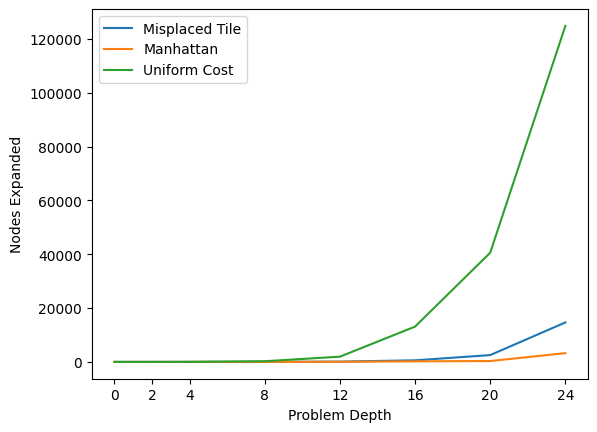

In [ ]:
#Epanded Nodes Plot
plt.plot(x_depth, mp_n, label='Misplaced Tile')
plt.plot(x_depth, mh_n, label='Manhattan')
plt.plot(x_depth, uc_n, label='Uniform Cost')
plt.xlabel("Problem Depth")
plt.ylabel("Nodes Expanded")
plt.xticks(x_depth)
plt.legend()

plt.show()

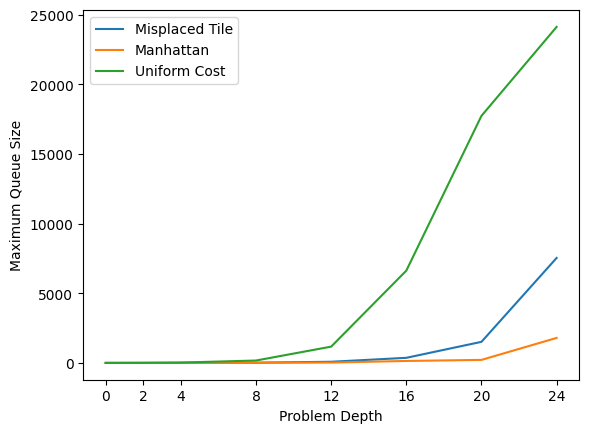

In [ ]:
#Queue Size Plot
plt.plot(x_depth, mp_q, label='Misplaced Tile')
plt.plot(x_depth, mh_q, label='Manhattan')
plt.plot(x_depth, uc_q, label='Uniform Cost')
plt.xlabel("Problem Depth")
plt.ylabel("Maximum Queue Size")
plt.xticks(x_depth)

plt.legend()

plt.show()

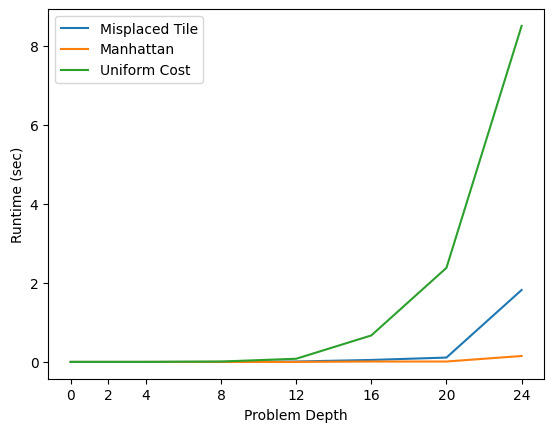

In [ ]:
#Runtime Plot
plt.plot(x_depth, mp_r, label='Misplaced Tile')
plt.plot(x_depth, mh_r, label='Manhattan')
plt.plot(x_depth, uc_r, label='Uniform Cost')
plt.xlabel("Problem Depth")
plt.ylabel("Runtime (sec)")
plt.xticks(x_depth)

plt.legend()

plt.show()

# Trace Printout

In [ ]:
easyProb = NPuzProb(test_puzzles[2])
easySoln = general_search(easyProb, manhattan_queuing)[0]

for n in ancestry(easySoln):
  print(n)
print()

hardProb = NPuzProb(test_puzzles[-1])
hardSoln = general_search(hardProb, manhattan_queuing)[0]

for n in ancestry(hardSoln):
  print(n)

Solution depth:  4  Maximum queue size:  7  Nodes visited:  5  Total runtime:  0.0
[1, 2, 3]
[5, 0, 6]
[4, 7, 8]
 g(n): 0 h(n): 0 f(n) 0
[1, 2, 3]
[0, 5, 6]
[4, 7, 8]
 g(n): 1 h(n): 3 f(n) 4
[1, 2, 3]
[4, 5, 6]
[0, 7, 8]
 g(n): 2 h(n): 2 f(n) 4
[1, 2, 3]
[4, 5, 6]
[7, 0, 8]
 g(n): 3 h(n): 1 f(n) 4
[1, 2, 3]
[4, 5, 6]
[7, 8, 0]
 g(n): 4 h(n): 0 f(n) 4

Solution depth:  26  Maximum queue size:  1796  Nodes visited:  3258  Total runtime:  0.16
[0, 7, 2]
[4, 6, 1]
[3, 5, 8]
 g(n): 0 h(n): 0 f(n) 0
[7, 0, 2]
[4, 6, 1]
[3, 5, 8]
 g(n): 1 h(n): 13 f(n) 14
[7, 6, 2]
[4, 0, 1]
[3, 5, 8]
 g(n): 2 h(n): 14 f(n) 16
[7, 6, 2]
[0, 4, 1]
[3, 5, 8]
 g(n): 3 h(n): 15 f(n) 18
[0, 6, 2]
[7, 4, 1]
[3, 5, 8]
 g(n): 4 h(n): 14 f(n) 18
[6, 0, 2]
[7, 4, 1]
[3, 5, 8]
 g(n): 5 h(n): 15 f(n) 20
[6, 4, 2]
[7, 0, 1]
[3, 5, 8]
 g(n): 6 h(n): 16 f(n) 22
[6, 4, 2]
[7, 1, 0]
[3, 5, 8]
 g(n): 7 h(n): 15 f(n) 22
[6, 4, 2]
[7, 1, 8]
[3, 5, 0]
 g(n): 8 h(n): 16 f(n) 24
[6, 4, 2]
[7, 1, 8]
[3, 0, 5]
 g(n): 9 h(n): 17 f(n) 

#Main function (custom testing)

In [ ]:
def main():
  size = int(input("Enter the size of n-puzzle you would like to solve (# of rows)."))
  print("Please enter a valid " + str(size) + "-puzzle to solve. Use spaces to delimit entries and 0 to represent the empty space.")

  rows = []
  for i in range(size):
    row = input("Enter row " + str(i + 1) + " ").split()
    for j in range(len(row)):
      row[j] = int(row[j])
    rows.append(row)
  print(rows)

  prob = NPuzProb(rows)
  soln = general_search(prob, manhattan_queuing)[0]

  for a in ancestry(soln):
    print(a)

if __name__ == "__main__":
  main()

Enter the size of n-puzzle you would like to solve (# of rows).2
Please enter a valid 2-puzzle to solve. Use spaces to delimit entries and 0 to represent the empty space.
Enter row 1 2 1
Enter row 2 3 0
[[2, 1], [3, 0]]


AttributeError: 'str' object has no attribute 'parent'